In [9]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
import numpy as np
from torchvision.datasets import FashionMNIST
from model import *
from group import *

(512, 512, 3)


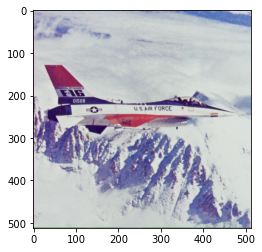

In [10]:
img = mpimg.imread("airplane.tiff")
print(img.shape)
plt.imshow(img)
plt.show()

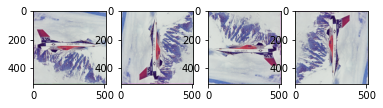

In [11]:
# Apply the group actions on an image and print (imshow) them
G = CyclicGroup()
elements = G.elements()
inp = transforms.ToTensor()(img)
rotated_imgs = G.action(elements, inp)
fig,axs = plt.subplots(1,4)
for i in range(4):
    axs[i].imshow(transforms.ToPILImage()(rotated_imgs[i]))
plt.show()

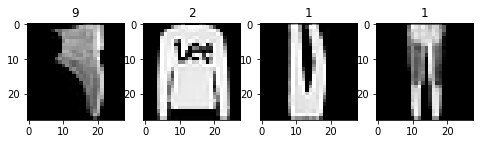

In [12]:
test_transf = transforms.Compose([transforms.ToTensor(), RandomRot90()])
test = FashionMNIST(root='./data', train=False, transform=test_transf, download=True)
# show a few samples from the testing set
n_samples = 4
fig, axs = plt.subplots(1,n_samples, figsize=(n_samples*2,2))
for i in range(n_samples):
    sample = test[i]
    axs[i].imshow(sample[0].squeeze(), cmap='gray')
    axs[i].set_title(sample[1])
plt.show()

In [13]:
# here we just load the final model
# In order to train it again run hw2.py
checkpoint_file = "./model.pt"
model = torch.load(checkpoint_file, map_location=torch.device('cpu'))

In [14]:
# print accuracy on the test set
trainer = Trainer()
trainer.run_trainer()

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Total accuracy: 88.220000%


In [15]:
vanilla_trainer = Trainer()
vanilla_trainer.checkpoint_file = "./vanilla_cnn_model.pt"
vanilla_trainer.run_trainer(use_vanilla=True)

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Total accuracy: 79.300000%


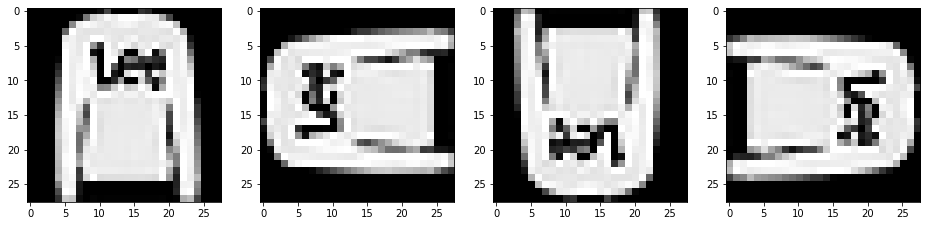

In [16]:
# show that the final representations are equivariant wrt 90-degree rotations
ex = test[1][0]
examples = torch.stack([torch.rot90(ex, i, dims=(-2,-1)) for i in range(4)])
fig, axs = plt.subplots(1,4, figsize=(16,16))
for i in range(4):
    axs[i].imshow(examples[i].squeeze(), cmap='gray')
plt.show()

In [17]:
# lift representation
# shape: (batch, hidden_channel, group_order, height, width)
examples = examples.to(trainer.device)
cpu = torch.device('cpu')
lifted_examples = trainer.model.convs[0](examples)
lifted_examples = lifted_examples.reshape(lifted_examples.shape[0], 
4, trainer.model.hidden_channel_number, lifted_examples.shape[2], lifted_examples.shape[3])

lifted_examples.shape


torch.Size([4, 4, 16, 28, 28])

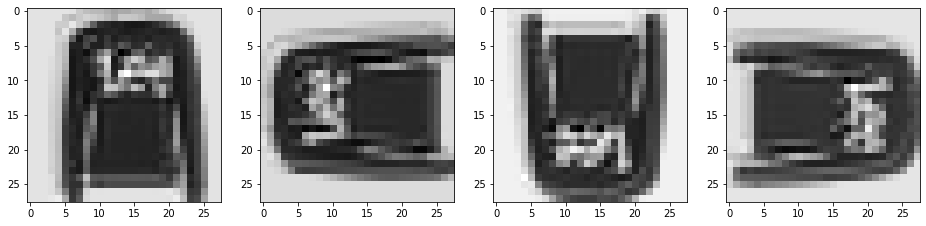

In [18]:
# as we can see applying the lifting convolutional layer to the rotated images
# results in a rotated representation, proving the equivariance of the layer
channel = 0
fig, axs = plt.subplots(1,lifted_examples.shape[0], figsize=(16,16))
for j in range(lifted_examples.shape[0]):
    axs[j].imshow(lifted_examples[j,0,channel].detach().to(cpu).numpy(), cmap='gray')
plt.show()

In [10]:
lifted_examples = trainer.model.convs[0](examples)
group_conv_examples = trainer.model.convs[2](lifted_examples)
group_conv_examples = group_conv_examples.reshape(group_conv_examples.shape[0], 
4, trainer.model.hidden_channel_number, group_conv_examples.shape[2], group_conv_examples.shape[3])
group_conv_examples.shape

torch.Size([4, 4, 16, 28, 28])

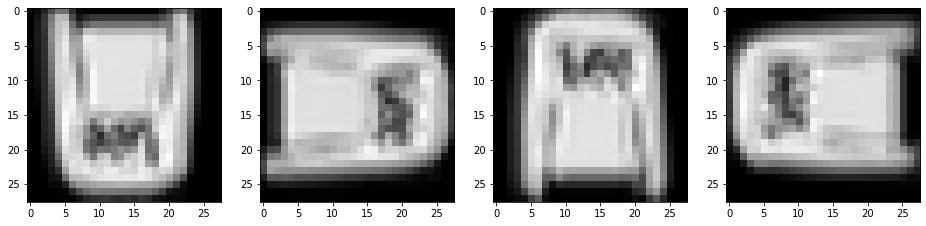

In [11]:
# as we can see applying the group convolutional layer to the rotated images
# results in a rotated representation, proving the equivariance of the layer
channel = 0
fig, axs = plt.subplots(1,group_conv_examples.shape[0], figsize=(16,16))
for j in range(group_conv_examples.shape[0]):
    axs[j].imshow((group_conv_examples[j,0,channel].detach().to(cpu).numpy()), cmap='gray')
plt.show()

In [36]:
projected_examples = trainer.model.convs(examples)
projected_examples = projected_examples.reshape(projected_examples.shape[0],4,trainer.model.hidden_channel_number,
projected_examples.shape[2], projected_examples.shape[3])
projected_examples = projected_examples.mean(dim=[1, -2, -1])

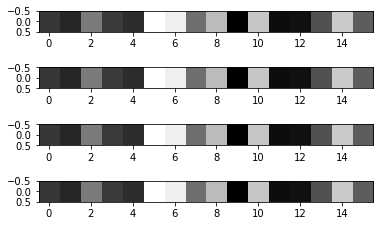

In [13]:
# as we can see after the coarsening of the network obtained after the pooling
# operation, the network yiedls the exact same representation for all the rotated images
# proving the complete invariance of the network to rotations
fig, axs = plt.subplots(len(CyclicGroup().elements()))
for i in range(len(CyclicGroup().elements())):
    axs[i].imshow(projected_examples[i, None].detach().to(cpu).numpy(), cmap='gray')
plt.show()

As we can see, the Group CNN is completely invariant to rotations without requiring any data augmentation. This is because this Group CNN is equivariant to $Z_4$. This is a very powerful property, and it is the reason why the group CNN is able to significantly outperform the vanilla CNN.

In [38]:
vanilla_projected_examples = vanilla_trainer.model.convs(examples)
vanilla_projected_examples = vanilla_projected_examples.reshape(vanilla_projected_examples.shape[0],vanilla_trainer.model.hidden_channel_number,
vanilla_projected_examples.shape[2], vanilla_projected_examples.shape[3])
vanilla_projected_examples = vanilla_projected_examples.mean(dim=[-2, -1])

In [39]:
vanilla_projected_examples.shape

torch.Size([4, 16])

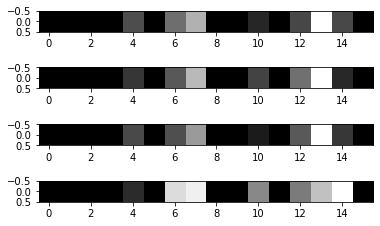

In [41]:
fig, axs = plt.subplots(len(CyclicGroup().elements()))
for i in range(len(CyclicGroup().elements())):
    axs[i].imshow(vanilla_projected_examples[i,None].detach().to(cpu).numpy(), cmap='gray')
plt.show()

As we can see, the vanilla CNN model, despite having been trained with data augmentation, yields features which are not invariant to rotations and, thus, it is less robust to them, providing an explanation for the gap in performance between the vanilla CNN and the Group CNN on the test set.